In [1]:
# Read result files

import pickle
import os
from collections import Iterable
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()
plt.rcParams.update({'font.size': 22})

/tmp/ipykernel_532769/4091605367.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Iterable


In [2]:
def flatten(lis):
     for item in lis:
        if isinstance(item, Iterable) and not isinstance(item, str):
            for x in flatten(item):
                yield x
        else:        
            yield item
            
def find(lst, s):
    return [i for i, x in enumerate(lst) if x==s]

def keys_exists(element, *keys):
    '''
    Check if *keys (nested) exists in `element` (dict).
    '''
    if not isinstance(element, dict):
        raise AttributeError('keys_exists() expects dict as first argument.')
    if len(keys) == 0:
        raise AttributeError('keys_exists() expects at least two arguments, one given.')

    _element = element
    for key in keys:
        try:
            _element = _element[key]
        except KeyError:
            return False
    return True

In [3]:
dataset = 'prison'

In [17]:
def compute_aggreated_results(algorithm):
    results_dict={}
    for file in [path for path in os.listdir('./') if algorithm in path]:
        with open(f'./{file}', 'rb') as handle:
            flatten_file_name = list(flatten([i.split('.') for i in file.split('_')]))
            idx_dataset_name = find(flatten_file_name, dataset)[0]
            sample = flatten_file_name[idx_dataset_name+1:-1][-1]
            version = flatten_file_name[idx_dataset_name+1:-1][-2]
            transformation = '_'.join(flatten_file_name[idx_dataset_name+1:-1][:-2])
            if not keys_exists(results_dict, transformation):
                results_dict[transformation] = {}
            if not keys_exists(results_dict, transformation, version): 
                results_dict[transformation][version] = {}
            if not keys_exists(results_dict, transformation, version, sample):    
                results_dict[transformation][version][sample] = {}

            results_dict[transformation][version][sample] = pickle.load(handle)
        handle.close()

    # shape=(transformation, version, sample, metric, dim)
    # metric = mase, rmse
    # dim = bottom, total, state, gender, legal, all

    df = pd.DataFrame.from_dict({(i,j, k, l): results_dict[i][j][k][l] 
                               for i in results_dict.keys() 
                               for j in results_dict[i].keys()
                               for k in results_dict[i][j].keys()
                               for l in results_dict[i][j][k].keys()},
                           orient='index')


    df_mase = df[np.in1d(df.index.get_level_values(3), ['mase'])]

    df_clean = df_mase.mean(level=(0,1,2)).stack(level=0).to_frame()

    df_clean = df_clean.reset_index()

    df_clean.columns = ['transformation', 'version', 'sample', 'group', 'mase']

    _, ax = plt.subplots(2, 2, figsize=(20, 20))
    ax = ax.ravel()
    transf = df_clean.transformation.unique()
    transf.sort()
    for i in range(len(transf)):
        fg = sns.lineplot(x='version', y='mase', hue='group', marker='o', data=df_clean.loc[df_clean['transformation']==transf[i]].sort_values(['version', 'group']), ax=ax[i])
        ax[i].set_ylim(0, 6.0)
        ax[i].set_title(transf[i], fontsize=22)

/tmp/ipykernel_532769/1000271449.py:34: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df_clean = df_mase.mean(level=(0,1,2)).stack(level=0).to_frame()


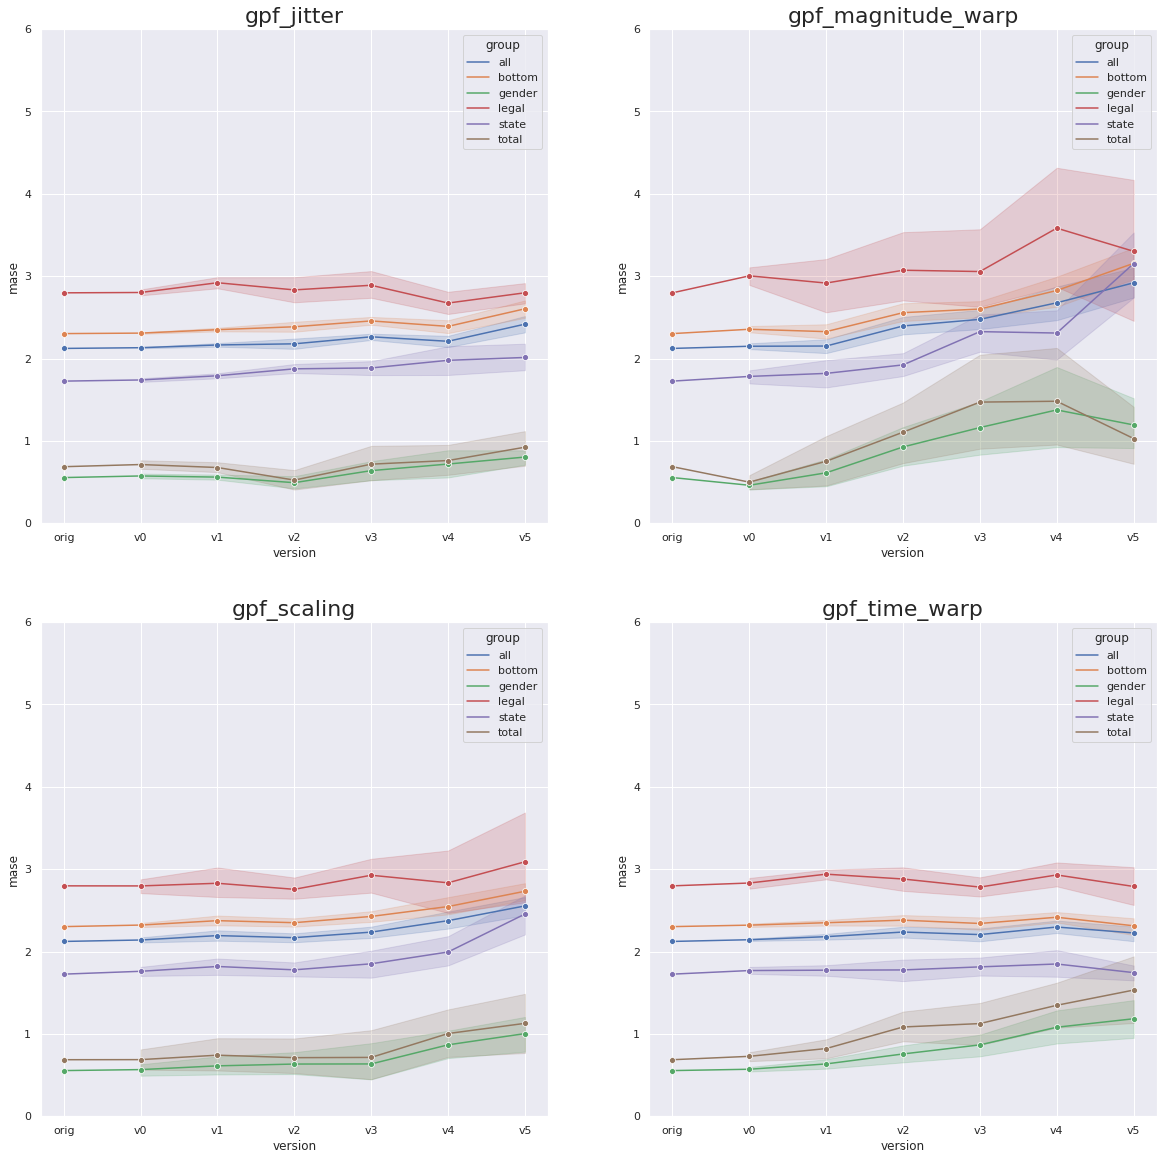

In [18]:
compute_aggreated_results('gpf')

/tmp/ipykernel_532769/1000271449.py:34: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df_clean = df_mase.mean(level=(0,1,2)).stack(level=0).to_frame()


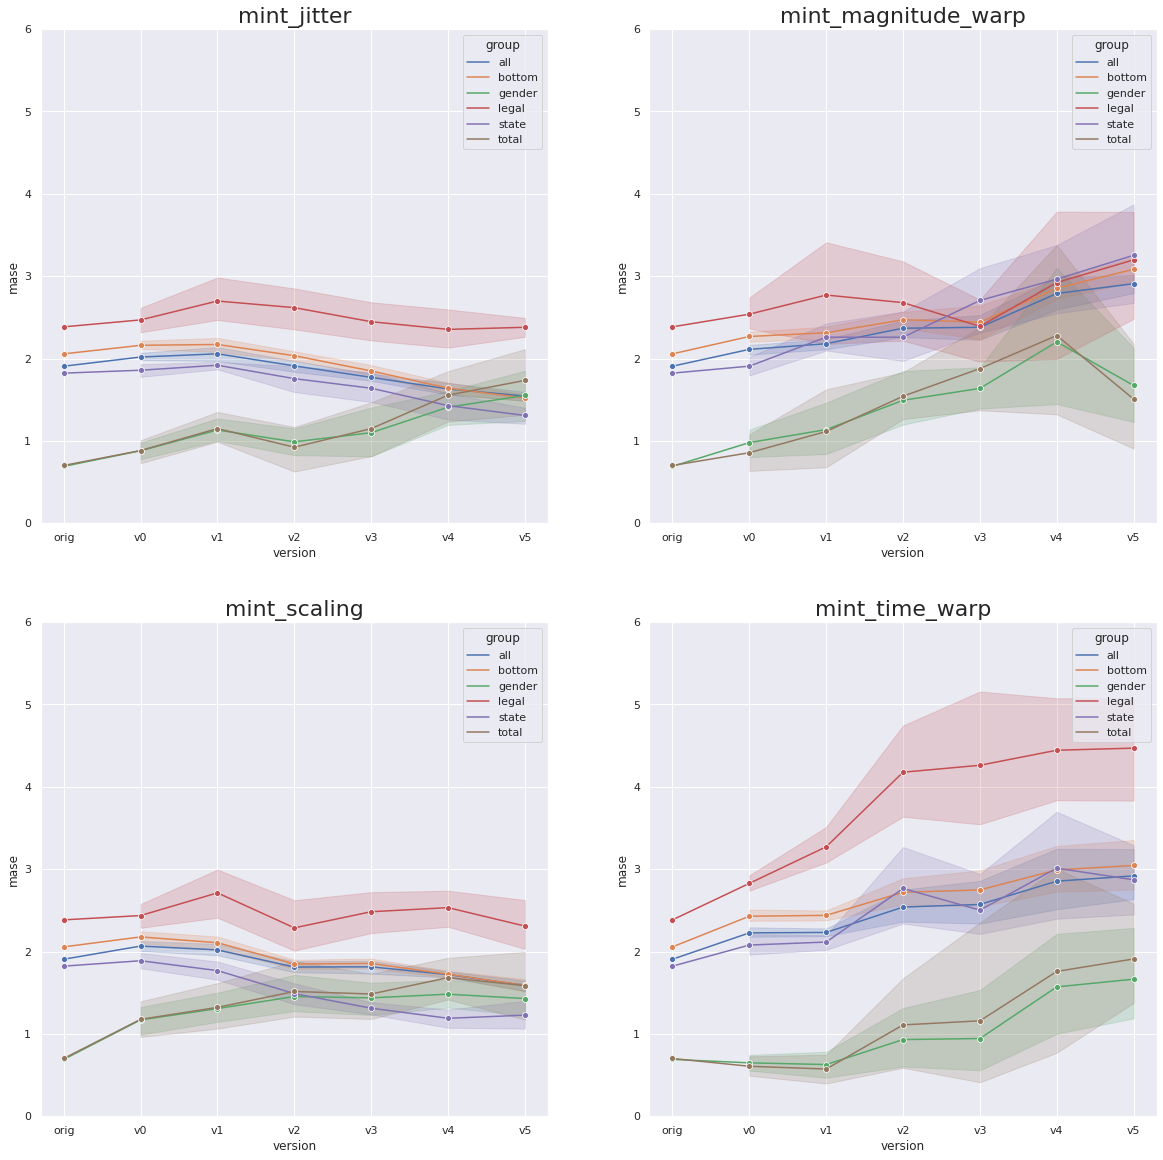

In [19]:
compute_aggreated_results('mint')

/tmp/ipykernel_532769/1000271449.py:34: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df_clean = df_mase.mean(level=(0,1,2)).stack(level=0).to_frame()


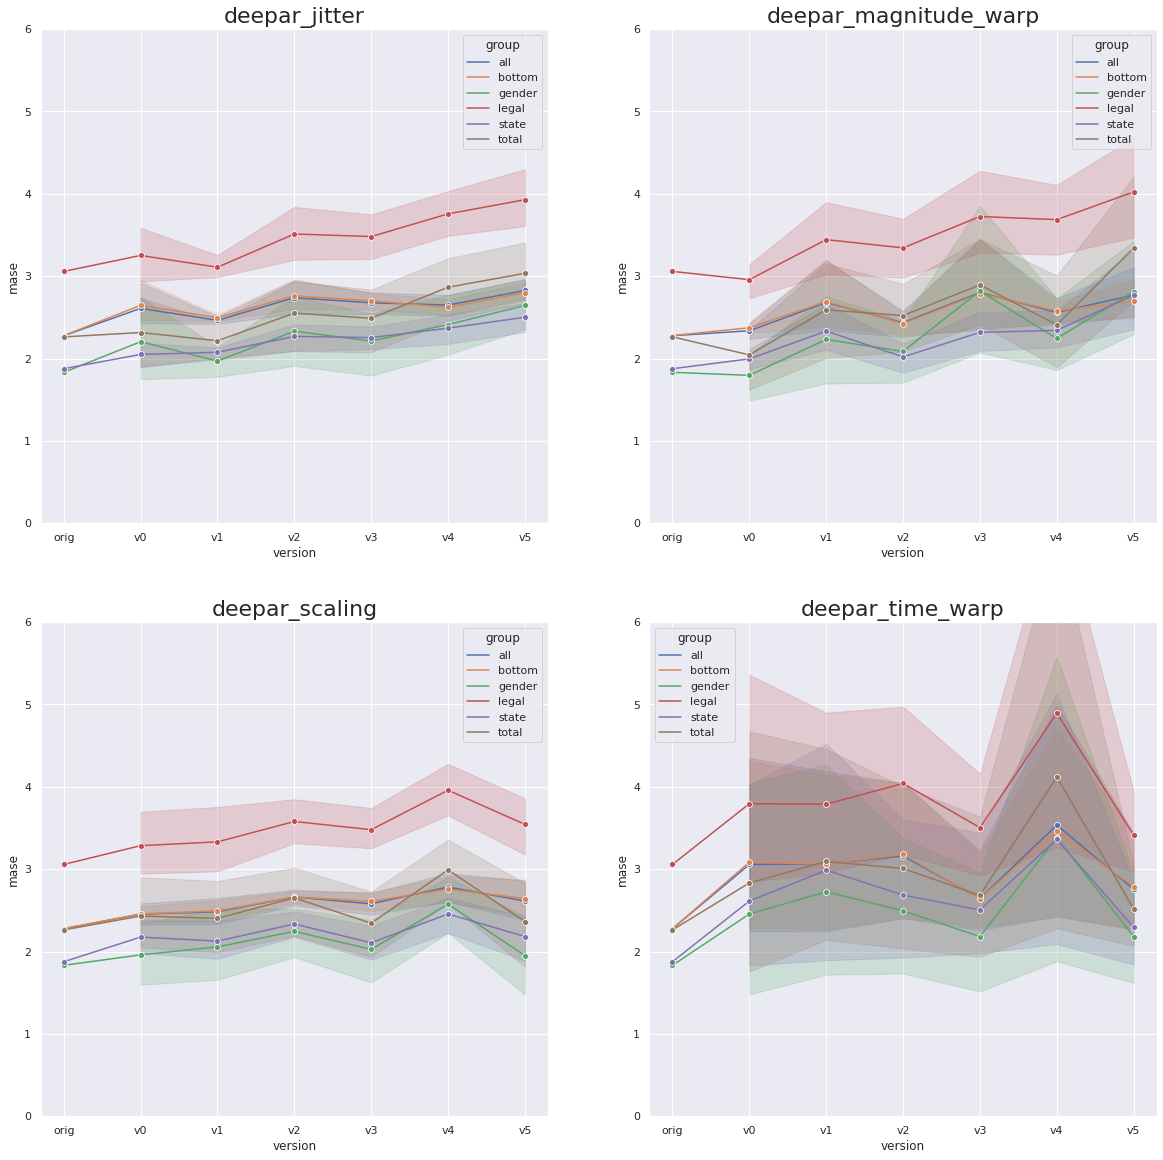

In [21]:
compute_aggreated_results('deepar')